# MISO voyage - I09S hydrographic section

<div style="float: right; margin-right: 20px; margin-left: 30px; width: 40%; max-width: 250px;">
    <img src="images/miso_path.jpg" width="100%"/>
</div> 

The MISO voyage on CSIRO research vessel RV Investigator sailed from Hobart on 5 January 2024.

MISO stands for: **M**ultidisciplinary **I**nvestigations of the **S**outhern **O**cean.

The aim of the 60-day voyage was to improve our ability to anticipate the impacts of future climate change. This voyage contributed to the GO-SHIP program's long term monitoring effort, which carries out repeated hydrographic transects (or cross sections) at key locations.

These surveys are typically carried out once a decade (at least) since the 1970s, in every ocean basin. ideally from coast to coast, and allow to monitor changes in the inventories of heat, freshwater, carbon, oxygen, nutrients, etc. This is an international effort: you can see a list of the countries involved [here](https://www.go-ship.org/RefSecs/goship_ref_secs.html).

Now you are going to work with the I09S cross section that runs from the Antarctic continent to Fremantle at around 120E. This line has been "occupied" four times during the years 1995, 2004/05, 2012 and the latest one during 2024 as part of the (MISO) voyage.

## Learning objectives

 - Understand how to open a large number of files (in this case CTD profiles) by searching a directory with `glob`, using an iteration and a dictionary structure.
 - Learn how to extract metadata (like the location of the profile).
 - Build an `xarray.DataArray` from the dictionary and assign the correct dimensions and coordinates.
 - How to interpolate a cross-section using `xarray.interp` and `metpy.interpolate`. Test different interpolation methods.
 - Analyse the cross-section and compare with a numerical model: biases, standard deviation, trends, etc.

In [1]:
# First step: load the libraries needed to run this notebook
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import glob
import gsw
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr

## Open I09S CTD profiles

In the `data/i09s_ctds/` you have around 60 CTD profiles. We want to open them using `xarray`, which is a great library for working with netcdf files. It let's you read the metadata, select according to dimension names (like `.sel(pressure = 100)` to select the values at a pressure of 100), carry out operations easily (like `.mean('time')` for a time average), and many other useful things. 

First lets get a list of the CTD files. Instead of writing the paths one by one, we can use the `glob` library to retrieve us all the netcdf files within a directory:

In [2]:
path_to_files = glob.glob('data/i09s_ctds/*Ctd*') 
path_to_files = np.sort(path_to_files)
path_to_files

array(['data/i09s_ctds\\in2024_v01034CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01035CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01036CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01037CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01038CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01039CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01040CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01044CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01045CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01046CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01047CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01048CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01049CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01050CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01051CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01052CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01053CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01054CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01055CtdAvg.nc',
       'data/i09s_ctds\\in2024_v01056CtdAvg.nc',
       'data/i09s_ct

Now we will iterate throught the list of files, and use `xarray.open_dataset` to open the profile and save it onto a dictionary of CTDs. A [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) let's you store data and access it through keys. In our case, we will use an index to access. So the key 0 corresponds to the first CTD profile in our list of files. 

Since we are at it, let's also create a list of latitudes and longitudes!

In [3]:
CTDs = {}; lat = []; lon = []
for i in range(0, len(path_to_files)):
    CTDs[i] = xr.open_dataset(path_to_files[i])
    lat.append(CTDs[i]['latitude'].item())
    lon.append(CTDs[i]['longitude'].item())

Let's do a quick plot of the locations using our `lat`, `lon` lists. We will use the mapping library `cartopy`, which allows you to make maps using different cartographic projections. You can specify the projection when you create the axis with the `fig.add_subplot()` line. 

Feel free to take a look at the [list of projections](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html) and modifying the code below to choose your own.

An important point about cartopy is that when plotting data on a map, you must add a transformation kwarg to the plotting command: `transform = ccrs.PlateCarree()`. If you don't do it, your data will no appear on the map. Try removing it and see for yourself!

### Activity

Play around with the map, changing projections, land colours, extent, gridlines, etc.

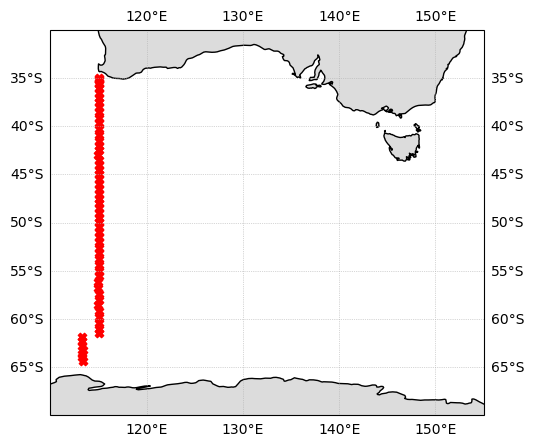

In [4]:
# Create a figure
fig = plt.figure(figsize = (10, 5))
# Create the map
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
# Set the limits for the map [lonE, lonW, latS, latN]
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
# Add land
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
# Add gridlines and format it to have degreeX labels
gl = ax.gridlines(draw_labels = True, linewidth = 0.5, linestyle = ':')
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()
# Plot locations
ax.scatter(lon, lat, marker = 'X', color = 'red', transform = ccrs.PlateCarree());

## Understanding the data

Let's look at just one CTD profile to see what it contains.

In [5]:
CTDs[0]

<xarray.Dataset>
Dimensions:              (time: 1, pressure: 2487, latitude: 1, longitude: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2024-02-01T09:46:24.669003776
  * pressure             (pressure) float64 2.265 3.0 ... 2.487e+03 2.488e+03
  * latitude             (latitude) float64 -64.34
  * longitude            (longitude) float64 113.4
Data variables: (12/28)
    woce_date            (time) float64 ...
    woce_time            (time) float64 ...
    temperature          (longitude, latitude, pressure, time) float64 ...
    temperatureFlag      (longitude, latitude, pressure, time) float32 ...
    conductivity         (longitude, latitude, pressure, time) float64 ...
    conductivityFlag     (longitude, latitude, pressure, time) float32 ...
    ...                   ...
    transmissometer      (longitude, latitude, pressure, time) float64 ...
    transmissometerFlag  (longitude, latitude, pressure, time) float32 ...
    fluorometer          (longitude, latitude, pressure, time) float64 ...
    fluorometerFlag      (longitude, latitude, pressure, time) float32 ...
    obs                  (longitude, latitude, pressure, time) float64 ...
    obsFlag              (longitude, latitude, pressure, time) float32 ...
Attributes: (12/14)
    WOCE_Version:    3.0
    Conventions:     COARDS/WOCE/CF-1.5
    History:         Created on 07-May-2024 11:45:48
    Organisation:    CSIRO Marine Research
    Survey:          in2024_v01
    Vessel:          Unknown
    ...              ...
    StartTime:       01-Feb-2024 09:46:24
    BottomTime:      01-Feb-2024 10:33:07
    EndTime:         01-Feb-2024 11:59:10
    WaterDepth:      2469.28
    MinAltitude:     Unknown
    PressureBin:     1

We have four dimensions (time, pressure, latitude and longitude) and 28 variables. In this tutorial we will only use `temperature` and `salinity`, which are the ones recorded by the primary sensors. You can see what units they're in. Under attributes there is information about who carried out the profile, in what voyage, etc. 

Let's become more familiar with `xarray` and try out a couple of operations:

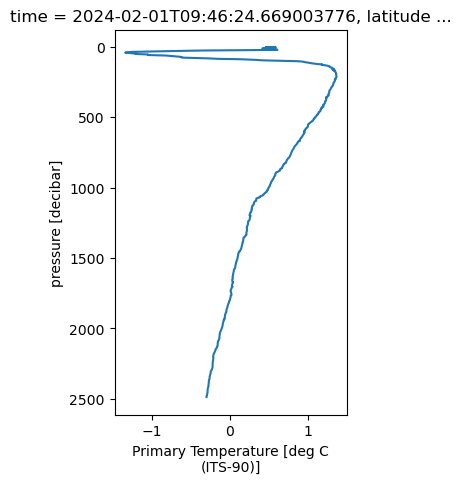

In [6]:
example_profile = CTDs[0]
temperature = example_profile['temperature']

# Plot it
temperature.plot(y = 'pressure', yincrease  = False, figsize = (3, 5));

Let's select and plot just the surface layer:

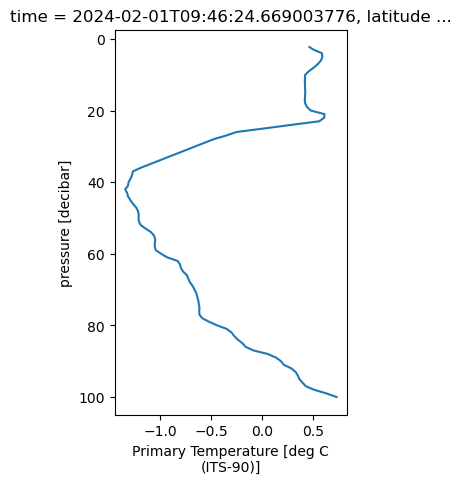

In [7]:
temperature.sel(pressure = slice(0, 100)).plot(y = 'pressure', yincrease  = False, figsize = (3, 5));

Let's calculate the average temperature of the mixed layer, and the temperature minimum value and location:

In [8]:
ml_temperature = temperature.sel(pressure = slice(0, 20)).mean('pressure')
print('The temperature of the ML is: '+ str(np.round(ml_temperature.item(), 2)) + 'degC')

temp_min = temperature.sel(pressure = slice(0, 100)).min('pressure')
location_of_min = temperature.sel(pressure = slice(0, 100)).argmin('pressure').item()
pressure_of_min = temperature['pressure'][location_of_min]
print('The minimum temperature is: '+ str(np.round(temp_min.item(), 2)) + 'degC at a pressure of ' + str(np.round(pressure_of_min.item(), 2)) + 'dbar')

The temperature of the ML is: 0.47degC
The minimum temperature is: -1.35degC at a pressure of 42.0dbar


### Activity

See if you can calculate the depth of the thermocline. Explore the salinity or oxygen variables. 

Can you associate some of the profile characteristics based to its location?

## Create a cross section

A cross-section is a 2D array with a vertical dimension, and a horizontal dimension. In our case because it is a meridional transect, we can use latitude as the horizontal dimension. To go from individual profiles to a cross-section, we need to do two things. 

First, we need to bring every profile to the same vertical levels. i.e. make the profiles have a common vertical dimension. Remember that each of these go to different depths, and might not have the exact same `pressure` values. We can do this by interpolating the pressure in each profile to a standard pressure array.

Second, we need to interpolate our horizontal dimension. These profiles are not evenly spaced in latitude, and they are not at the same longitude either. We would like our cross-section to be evenly spaced, say every quarter of a degree. This interpolation is a bit more involved - so we will do it at the end.

### Vertical interpolation

We will use `xarray.interp()` function. We will iterate through the CTD profiles, and interpolate to a target pressure that goes between 0 and 6000dbar every 1dbar. We will choose a linear interpolation, but there are other methods available. Feel free to explore how the results differ by choosing other interpolation methods.

In [9]:
target_pressure = np.arange(1, 6001, 1)
CTDs_interp = {}
for k in list(CTDs.keys()):
    CTDs_interp[k] = CTDs[k].interp(pressure = target_pressure, method = 'linear')

Now that our CTD profiles have been interpolated to the same vertical levels, we can arrange the variables of interest (temperature and salinity) onto 2D arrays, where the horizontal dimension will be for now `CTD_number`. This means that from now on, we will be working with `xarray.DataArray` instead of dictionaries. 

In [10]:
# Create empty arrays with the appropriate dimensions and coordinates
temperature = xr.DataArray(data = np.empty([len(target_pressure), len(path_to_files)]),
                           coords = {'pressure': target_pressure,
                                     'CTD_number': np.arange(0, len(path_to_files), 1)})

salinity = xr.DataArray(data = np.empty([len(target_pressure), len(path_to_files)]),
                        coords = {'pressure': target_pressure,
                                  'CTD_number': np.arange(0, len(path_to_files), 1)})
# Iterate through our dictionary of CTDs, and fill in the empty arrays
for i in range(0, len(path_to_files)):
    temperature.loc[{'CTD_number':i}] = CTDs_interp[i]['temperature'].squeeze().values
    salinity.loc[{'CTD_number':i}] = CTDs_interp[i]['salinity'].squeeze().values

Let's do a quick plot to see what, e.g. temperature, looks like:

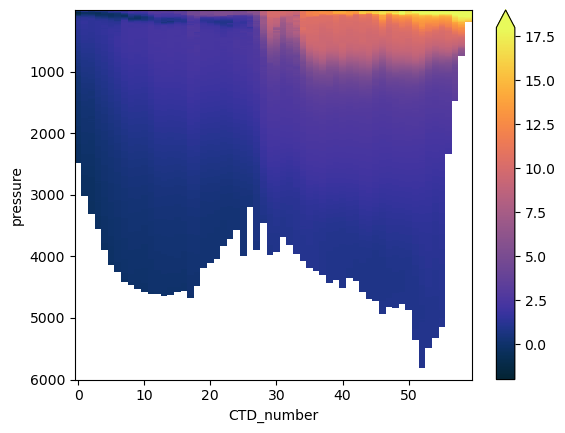

In [11]:
temperature.plot(y = 'pressure', yincrease = False, vmin = -2, vmax = 18, cmap = cm.cm.thermal);

It already resembles a cross section! 


### Horizontal interpolation

We will do this using `metpy.interpolate.interpolate_to_points`. We need to feed this function three things:
- The original locations of the observations, which we will call `points`
- The values of the observations at these locations, in our case temperature, which we will call `values`
- The target locations of interpolation, the Easy Ocean locations, which we will call `xi`

You can use `help()` to access the documentation.

In [12]:
points = np.stack([lon, lat], axis = 1)
print('The shape of points is :'+str(np.shape(points)))

values = temperature.T.values
print('The shape of values is :'+str(np.shape(values)))

target_latitude = np.arange(-65, -34.75, .25)
xi = np.stack([np.ones(len(target_latitude))*114.7, 
               target_latitude], axis = 1)
print('The shape of xi is :'+str(np.shape(xi)))

The shape of points is :(60, 2)
The shape of values is :(60, 6000)
The shape of xi is :(121, 2)


In [13]:
temperature_interp = metpy.interpolate.interpolate_to_points(points, values, xi, interp_type = 'nearest')
# Create a dataarray
temperature_interp = xr.DataArray(temperature_interp.T, 
                                  coords = {'pressure': target_pressure,
                                            'latitude': target_latitude},
                                  name = 'temperature')

In [14]:
salinity_interp = metpy.interpolate.interpolate_to_points(points, salinity.T.values, xi, interp_type = 'nearest')
# Create a dataarray
salinity_interp = xr.DataArray(salinity_interp.T, 
                                  coords = {'pressure': target_pressure,
                                            'latitude': target_latitude},
                                  name = 'temperature')

Let's plot temperature and salinity in the same figure. To do this, we need to create two axis, one for each variable, which is done easily within the `plt.subplots()` function.

As there is more than one subplot, you now need to specify in which one you'd like the data plotted within the `.plot()` function.

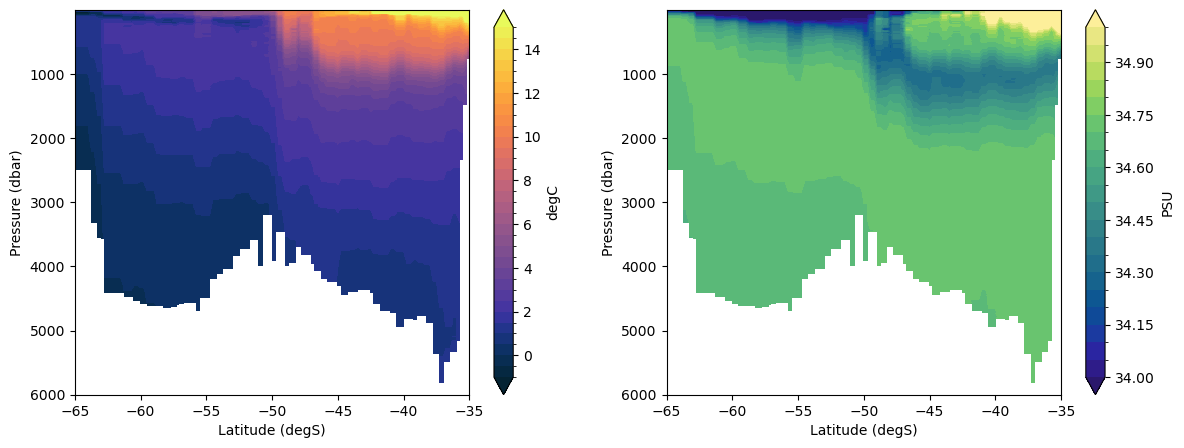

In [15]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 5))
temperature_interp.plot.contourf(ax = axs[0], vmin = -1, vmax = 15, levels = 33, cmap = cm.cm.thermal,
                                 yincrease = False, cbar_kwargs = {'label':'degC'})
salinity_interp.plot.contourf(ax = axs[1], vmin = 34, vmax = 35, levels = 21, cmap = cm.cm.haline,
                              yincrease = False, cbar_kwargs = {'label':'PSU'})
# Let's make nice labels for the axis
for ax in axs:
    ax.set_xlabel('Latitude (degS)')
    ax.set_ylabel('Pressure (dbar)')

## INSERT DESCRIPTION OF WATER MASSES AND WHATEVER SCIENCE FEATURES YOU WISH TO DISCUSS HERE

### Activity

You can try to repeat the interpolation steps for the oxygen variable.

## Comparison with ACCESS-OM2

ACCESS-OM2 is Australia's ocean/sea ice model. It is developed and maintained by the COSIMA community and is available in several different configurations, including different horizontal resolutions and applied forcing. The COSIMA community also maintains a repository with python code used to analyse model output, called the [COSIMA recipes](https://github.com/COSIMA/cosima-recipes).

We will compare the I09S cross-section from the MISO voyage to the model's output. The configuration we will use is the highest horizontal resolution (0.1 $^{\circ}$) from an experiment that has been forced with a prescribed atmosphere from a reanalysis product from 1958 to 2018. 

The model's cross-section at the longitude clossest to I09S is prepared for you. We just need to open it. 

In [16]:
model_temperature = xr.open_dataarray('data/access_temp_i09s.nc')-273.15 # Model's temperature comes in Kelvin
model_salinity = xr.open_dataarray('data/access_salt_i09s.nc')

In [17]:
model_temperature

<xarray.DataArray 'temp' (time: 225, st_ocean: 75, yt_ocean: 489)>
array([[[-1.6459045 , -1.6139526 , -1.6011963 , ..., 21.774506  ,
         21.92627   , 22.080353  ],
        [-1.6392822 , -1.6070862 , -1.5941772 , ..., 21.784882  ,
         21.937317  , 22.091858  ],
        [-1.6365356 , -1.604248  , -1.5912781 , ..., 21.78775   ,
         21.94104   , 22.095795  ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.8343811 , -1.8220825 , -1.8049011 , ..., 21.491577  ,
         21.582306  , 21.631744  ],
        [-1.8328857 , -1.820282  , -1.8027954 , ..., 21.503632  ,
         21.595062  , 21.644043  ],
        [-1.8322144 , -1.819458  , -1.8017883 , ..., 21.507996  ,
         21.59964   , 21.64862   ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.48147583,  0.6080322 ,  0.69039917, ..., 18.355835  ,
         18.66391   , 18.734802  ],
        [ 0.57901   ,  0.65301514,  0.6768799 , ..., 18.350555  ,
         18.660583  , 18.731445  ],
        [ 0.5802307 ,  0.64230347,  0.6578369 , ..., 18.342499  ,
         18.65332   , 18.723663  ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
    xt_ocean  float64 ...
  * yt_ocean  (yt_ocean) float64 -64.97 -64.93 -64.89 ... -35.2 -35.12 -35.04
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 2000-04-16 ... 2018-12-16T12:00:00

The dimensions of the model are time, xt_ocean, yt_ocean and st_ocean. The t_ocean dimensions are longitude, latitude and depth.

As a first step, we can plot the observations next to the model's time mean cross section. Remember that to do a time mean, you just need to do `.mean('time')`.

This time, our figure will have four panels. 

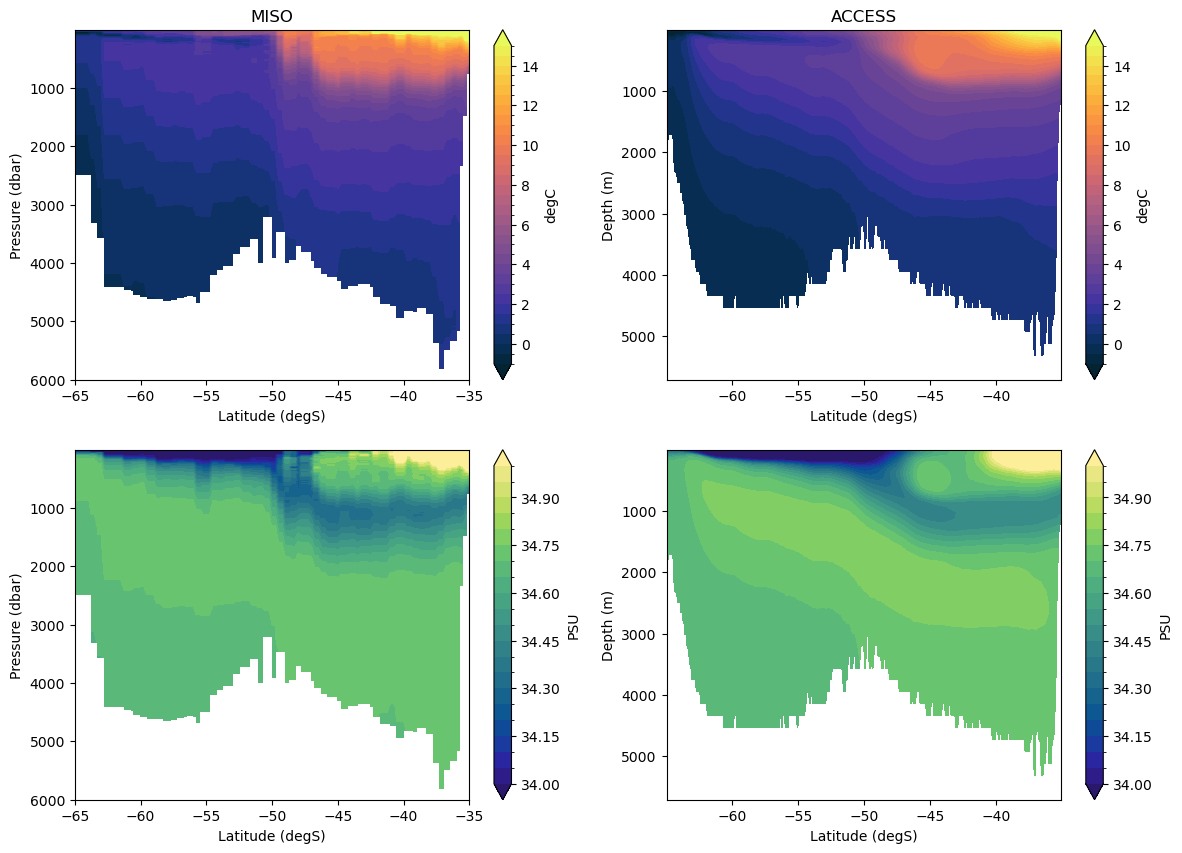

In [18]:
fig, axs = plt.subplots(2, 2, figsize = (14, 10))
temperature_interp.plot.contourf(ax = axs[0,0], vmin = -1, vmax = 15, levels = 33, cmap = cm.cm.thermal,
                                 yincrease = False, cbar_kwargs = {'label':'degC'})
salinity_interp.plot.contourf(ax = axs[1,0], vmin = 34, vmax = 35, levels = 21, cmap = cm.cm.haline,
                              yincrease = False, cbar_kwargs = {'label':'PSU'})
axs[0,0].set_ylabel('Pressure (dbar)'); axs[1,0].set_ylabel('Pressure (dbar)')

model_temperature.mean('time').plot.contourf(ax = axs[0,1], vmin = -1, vmax = 15, levels = 33, cmap = cm.cm.thermal,
                                 yincrease = False, cbar_kwargs = {'label':'degC'})
model_salinity.mean('time').plot.contourf(ax = axs[1,1], vmin = 34, vmax = 35, levels = 21, cmap = cm.cm.haline,
                                 yincrease = False, cbar_kwargs = {'label':'PSU'})
axs[0,1].set_ylabel('Depth (m)'); axs[1,1].set_ylabel('Depth (m)')
# Make nice labels
for ax in axs.flatten():
    ax.set_xlabel('Latitude (degS)')
    ax.set_title('')
axs[0,0].set_title('MISO')
axs[0,1].set_title('ACCESS');

As you can see, the model is able to capture the large scale structure of this cross-section. You can clearly see the subduction of fresh Antarctic Intermediate Waters, and the saltier North Atlantic Deep Water upwelling towards the south, the cold signal of Antarctic Bottom Water at the bottom close to the Antarctic margins, etc.

The cross-section we made from CTD profiles looks less smooth that the model. This is normal - to do a proper cross-section, several filtering techniques should be used as well, but these are out of the scope of this class. The observations are also a "snapshot" of the ocean at that time, so they contain high frequency variability (like eddies and meanders, more visible in the upper layers), that are smoothed out in the model's time-mean.

## Biases

Let's look at the model's bias with respect to observations. This is essentially the difference between the observed I09S and the model's representation. Note that (a) the model's vertical coordinate is depth, not pressure and (b) the latitude dimension is not exactly the same.  

This means we first need to convert the vertical dimension to pressure. This can be done with the `gsw` library, which contains a lot of super useful functions for oceanography given by the thermodynamic equation of state of sea water. For example, it allows to convert between temperature/salinity types, calculate density, etc. And secondly, we need to interpolate the model to the observations' latitude dimension.

In [19]:
pressure_model = gsw.p_from_z(-model_temperature['st_ocean'], -50)
model_temperature['st_ocean'] = pressure_model
model_temperature = model_temperature.rename({'st_ocean':'pressure', 'yt_ocean':'latitude'})

In [20]:
model_salinity['st_ocean'] = pressure_model
model_salinity = model_salinity.rename({'st_ocean':'pressure', 'yt_ocean':'latitude'})

Now we can do the interpolation using xarray:

In [21]:
model_temperature_interp = model_temperature.interp(pressure = temperature_interp['pressure'], latitude = temperature_interp['latitude'])
model_salinity_interp = model_salinity.interp(pressure = salinity_interp['pressure'], latitude = salinity_interp['latitude'])

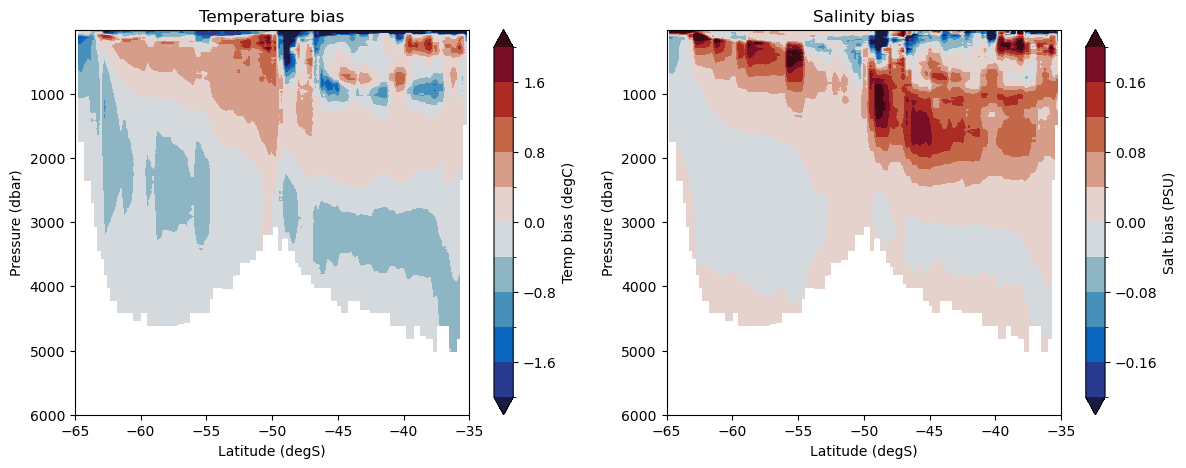

In [23]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 5))
(model_temperature_interp.mean('time') - temperature_interp).plot.contourf(ax = axs[0], vmin = -2, vmax = 2, levels = 11, cmap = cm.cm.balance,
                                 yincrease = False, cbar_kwargs = {'label':'Temp bias (degC)'})
(model_salinity_interp.mean('time') - salinity_interp).plot.contourf(ax = axs[1], vmin = -.2, vmax = .2, levels = 11, cmap = cm.cm.balance,
                                 yincrease = False, cbar_kwargs = {'label':'Salt bias (PSU)'})
for ax in axs:
    ax.set_xlabel('Latitude (degS)')
    ax.set_ylabel('Pressure (dbar)')
axs[0].set_title('Temperature bias'); 
axs[1].set_title('Salinity bias');

There's a salty bias in the model in the layers corresponding to NADW and AAIW. The dipole at 50S in the temperature biases is due to the ACC fronts shifted a bit in the model compared to obs - it is not that big of a deal.

We can look at the model's standard deviation, to see whether these biases fall within their magnitude, or if they're outside what we would call "intrinsic" variability in the model. Remember that we are comparing a time mean with a snapshot, the later being subject to high frequency variability that is averaged out when taking the time mean. 

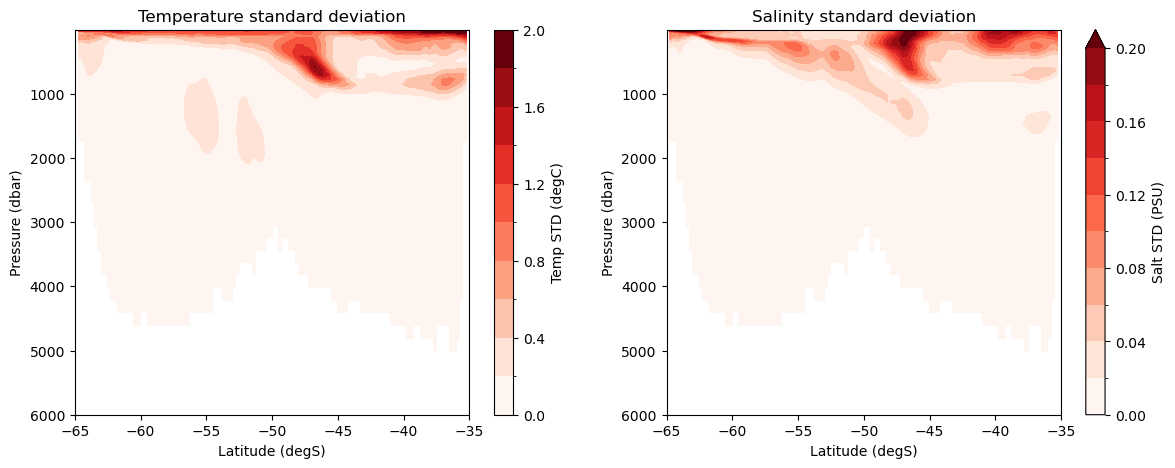

In [24]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 5))
model_temperature_interp.std('time').plot.contourf(ax = axs[0], vmin = 0, vmax = 2, levels = 11, cmap = 'Reds',
                                 yincrease = False, cbar_kwargs = {'label':'Temp STD (degC)'})
model_salinity_interp.std('time').plot.contourf(ax = axs[1], vmin = 0, vmax = .2, levels = 11, cmap = 'Reds',
                                 yincrease = False, cbar_kwargs = {'label':'Salt STD (PSU)'})
for ax in axs:
    ax.set_xlabel('Latitude (degS)')
    ax.set_ylabel('Pressure (dbar)')
axs[0].set_title('Temperature standard deviation'); 
axs[1].set_title('Salinity standard deviation');

The biases do exceed the standard deviation. This is not uncommon - models like this one are usually initialised from an "observed ocean state", but are freely evolving afterwards. As model time goes by, they tend to drift away from observations, and so biases increase with time. 

This means that looking at specific values of temperature and salinity in a water mass in a model is probably not useful/relevant. But what matters is the representation of processes - i.e. does the circulation intensify with stronger winds, do the bottom waters warm throughout time, etc. Is there a trend throughout the study period?

## Trend calculation

To calculate trends, we can use a python package developed by members of the COSIMA community, `xarrayMannKendall`.

In [25]:
import xarrayMannKendall as xrmk

To do the MannKenndall trend test, we need to specify along which dimension we want the trent calculated (in this case time), and tell it how are the x and y coordinates called.

In [28]:
MK_class = xrmk.Mann_Kendall_test(model_temperature, 
                                  'time',
                                  coords_name = {'time':'time', 'latitude':'x', 'pressure':'y'})
temp_trends = MK_class.compute()

c:\Users\jmneme\AppData\Local\miniconda3\envs\ksa206\Lib\site-packages\xarrayMannKendall\decorators.py:38: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.DataArray = self.DataArray.rename(rename_dict)


Now that we've calculated the trends, let's rename `x` and `y` to `latitude` and `pressure`, and retrieve the land as nans.

In [29]:
temp_trends = temp_trends.rename({'x':'latitude', 'y':'pressure'})
temp_trends = temp_trends.where(~np.isnan(model_temperature.isel(time = 0)))

Do the same for salinity

In [32]:
MK_class = xrmk.Mann_Kendall_test(model_salinity, 
                                  'time',
                                  coords_name = {'time':'time', 'latitude':'x', 'pressure':'y'})
salt_trends = MK_class.compute()

c:\Users\jmneme\AppData\Local\miniconda3\envs\ksa206\Lib\site-packages\xarrayMannKendall\decorators.py:38: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.DataArray = self.DataArray.rename(rename_dict)


In [33]:
salt_trends = salt_trends.rename({'x':'latitude', 'y':'pressure'})
salt_trends = salt_trends.where(~np.isnan(model_salinity.isel(time = 0)))

Because we had monthly data, these trends are in units of variable per month. Since we care about long term changes, we can multiply the trends by 120 and convert it to units of varible per decade.

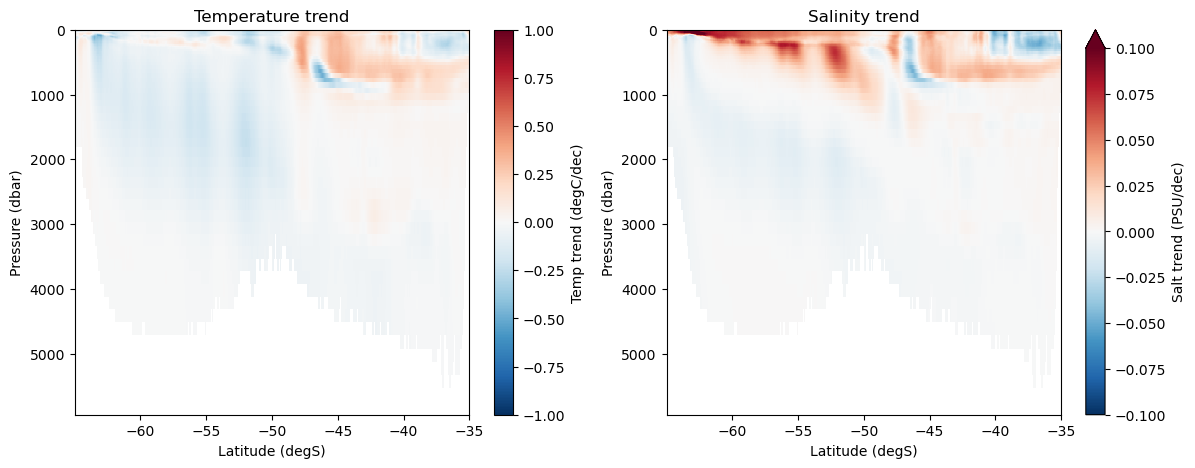

In [34]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 5))
(120*temp_trends['trend']).plot(ax = axs[0], vmin = -1, vmax = 1, cmap = 'RdBu_r',
                                 yincrease = False, cbar_kwargs = {'label':'Temp trend (degC/dec)'})
(120*salt_trends['trend']).plot(ax = axs[1], vmin = -.1, vmax = .1, cmap = 'RdBu_r',
                                 yincrease = False, cbar_kwargs = {'label':'Salt trend (PSU/dec)'})
for ax in axs:
    ax.set_xlabel('Latitude (degS)')
    ax.set_ylabel('Pressure (dbar)')
axs[0].set_title('Temperature trend');
axs[1].set_title('Salinity trend');

# Key takeaways

 - `xarray` is an extremely powerful library for working with multi-dimensional arrays. It allows us to select, slice, and carry out basic operations using dimension names. You can even plot with xarray!
 - CTD profiles require a bit of manipulating before they can be converted to a cross-section. 

## INSERT SCIENCE CONCLUSIONS